In [1]:
import numpy as np
from astropy.stats import LombScargle
import matplotlib.pyplot as plt

In [2]:
# Read the data
date, rv, rverr, ha, haerr, nad, naderr, fwhm, fwhmerr, bis, biserr = \
    np.loadtxt("dbf_HARPS.txt", unpack=True, \
    usecols=[1,2,3,4,5,6,7,8,9,10,11], skiprows=21)
dateH, rvH, rverrH, haH, haerrH = \
    np.loadtxt("dbf_HIRES.txt", unpack=True, \
    usecols=[1,2,3,4,5])
first = date[0]
date -= first
dateH -= first
# Put together the HIRES and HARPS measurements of RV and Halpha
alldates = np.concatenate((date, dateH))
allRV = np.concatenate((rv, rvH))
allRVerr = np.concatenate((rverr, rverrH))
allha = np.concatenate((ha, haH))
allhaerr = np.concatenate((haerr, haerrH))
sub = np.argsort(alldates)
alldates = alldates[sub]
allRV = allRV[sub]
allRVerr = allRVerr[sub]
allha = allha[sub]
allhaerr = allhaerr[sub]
# Compute the periodograms
xiR, powR = LombScargle(alldates, allRV, allRVerr).autopower()
xiH, powH = LombScargle(alldates, allha, allhaerr).autopower()

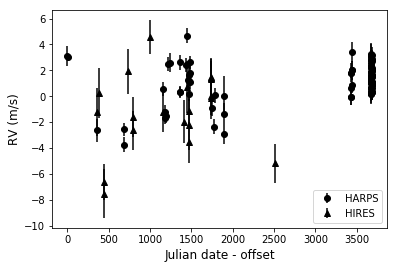

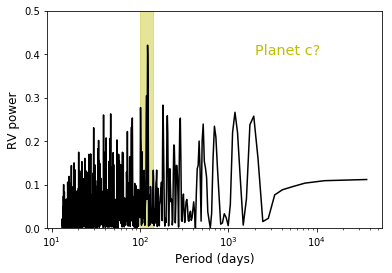

In [3]:
# Plot RV and periodogram
xpts = [101, 106, 111, 116, 121, 126, 131, 136, 141]
ypts = np.ones(9)
plt.figure()
plt.errorbar(date, rv, yerr=rverr, fmt='o', color='k', label="HARPS")
plt.errorbar(dateH, rvH, yerr=rverrH, fmt='^', color='k', label="HIRES")
plt.legend(loc="lower right")
plt.ylabel("RV (m/s)", fontsize='large')
plt.xlabel("Julian date - offset", fontsize="large")
plt.figure()
plt.plot(1./xiR, powR, 'k-')
plt.fill_between(xpts, ypts, color="y", alpha=0.4)
plt.ylim([0,0.5])
plt.ylabel("RV power", fontsize="large")
plt.xlabel("Period (days)", fontsize="large")
plt.text(2000,0.4,"Planet c?", color="y", fontsize="x-large")
plt.xscale("log")

In [4]:
from george import kernels
from george import GP
from george import modeling
from scipy.optimize import minimize

# Initial guesses for the hyperparameters
constant_guess = 8. 
metric_guess = 50000. 
period_guess = 110.0 
gamma_guess = 3. 

# Create the kernels
kexp2 = constant_guess * kernels.ExpSquaredKernel(metric=metric_guess)
kper = kernels.ExpSine2Kernel(gamma=gamma_guess, log_period=np.log(period_guess))
krot = kexp2 * kper

# Trivial function that returns the white noise amplitudes.
# Note: I'm not 100% sure I'm treating the measurement uncertainties correctly.
def whitenoise(time):
    return np.log(allRVerr**2)

# Initialize the Gaussian process. 
gp = GP(krot, fit_kernel=True, mean=np.mean(allRV), \
        white_noise=modeling.CallableModel(whitenoise, gradient=None))

# Define the objective function that will be used to evaluate the goodness of the fitted
# hyperparameters (negative log-likelihood in this case)
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(allRV, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# Find the gradient of the objective function nll
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(allRV, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(alldates)

# Print the initial ln-likelihood.
print("Initial ln-likelihood:", gp.log_likelihood(allRV))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print("Final ln-likelihood:", gp.log_likelihood(allRV))

# Display results
print(results)
print(gp.get_parameter_names())

Initial ln-likelihood: -208.44136596098863
Final ln-likelihood: -208.23230702739988
      fun: 208.23230702739988
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.53375143e-05,  1.10544919e-05, -5.19362594e-06, -7.94856579e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 30
      nit: 24
   status: 0
  success: True
        x: array([ 2.05877994, 11.14374426,  2.90377567,  4.70303061])
('kernel:k1:k1:log_constant', 'kernel:k1:k2:metric:log_M_0_0', 'kernel:k2:gamma', 'kernel:k2:log_period')


In [5]:
# Human-readable results
print("Constant kernel multiplier:", np.exp(results.x[0]))
print("Sqrt of constant kernel multiplier (physically meaningful):", np.sqrt(np.exp(results.x[0])))
print("Metric:", np.exp(results.x[1]))
print("Decorrelation timescale (sqrt of metric):", np.sqrt(np.exp(results.x[1])), " days")
print("Gamma (multiplier of sin2):", results.x[2])
print("Roughness parameter omega:", np.sqrt(0.5/results.x[2]))
print("Period:", np.exp(results.x[3]))

Constant kernel multiplier: 7.836403106984467
Sqrt of constant kernel multiplier (physically meaningful): 2.7993576239888442
Metric: 69130.013403064
Decorrelation timescale (sqrt of metric): 262.92587054731604  days
Gamma (multiplier of sin2): 2.9037756700767665
Roughness parameter omega: 0.4149573591895746
Period: 110.28088515430954


In [6]:
import emcee

# Try to make some reasonable priors
def lnprior(pars):
    ln_decorr_time2 = pars[1] # This parameter is ln((decorrelation time)^2)
    ln_period = pars[3]
    # Uniform prior between 5 days and 4 x length of the time series for decorrelation time
    if ((ln_decorr_time2 < np.log(5.**2.)) or (ln_decorr_time2 > np.log(alldates[-1]**2.))):
        return -np.inf
    # Uniform prior for period between 2 days and the 4*length of the time series
    if ((ln_period < np.log(2.)) or (ln_period > np.log(4.*alldates[-1]))):
        return -np.inf
    # Uniform, barely informative priors for the other parameters
    for i in (0, 2):
        if ((pars[i] < -7.) or (pars[i] > 8.)):
            return -np.inf
    return 0.

# The full log-probability function, including priors
def lnprob(pars):
    gp.set_parameter_vector(pars)
    ll = gp.log_likelihood(allRV, quiet=True)
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ll

# Run the Gaussian process again
gp.compute(alldates)
print("Computed the Gaussian process")

# Set up the sampler.
nwalkers, ndim = 100, len(gp)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
p0 = gp.get_parameter_vector() + 1.0e-4 * np.random.randn(nwalkers, ndim)

print("Running burn-in")
nburn = 100
p0, _, _ = sampler.run_mcmc(p0, nburn)

print("Running production chain")
nproduce = 2000
sampler.run_mcmc(p0, nproduce)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Computed the Gaussian process
Running burn-in
Running production chain
Mean acceptance fraction: 0.323


/Users/student/anaconda3/lib/python3.6/site-packages/george/utils.py:30: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


Text(0,0.5,'RV (m/s)')

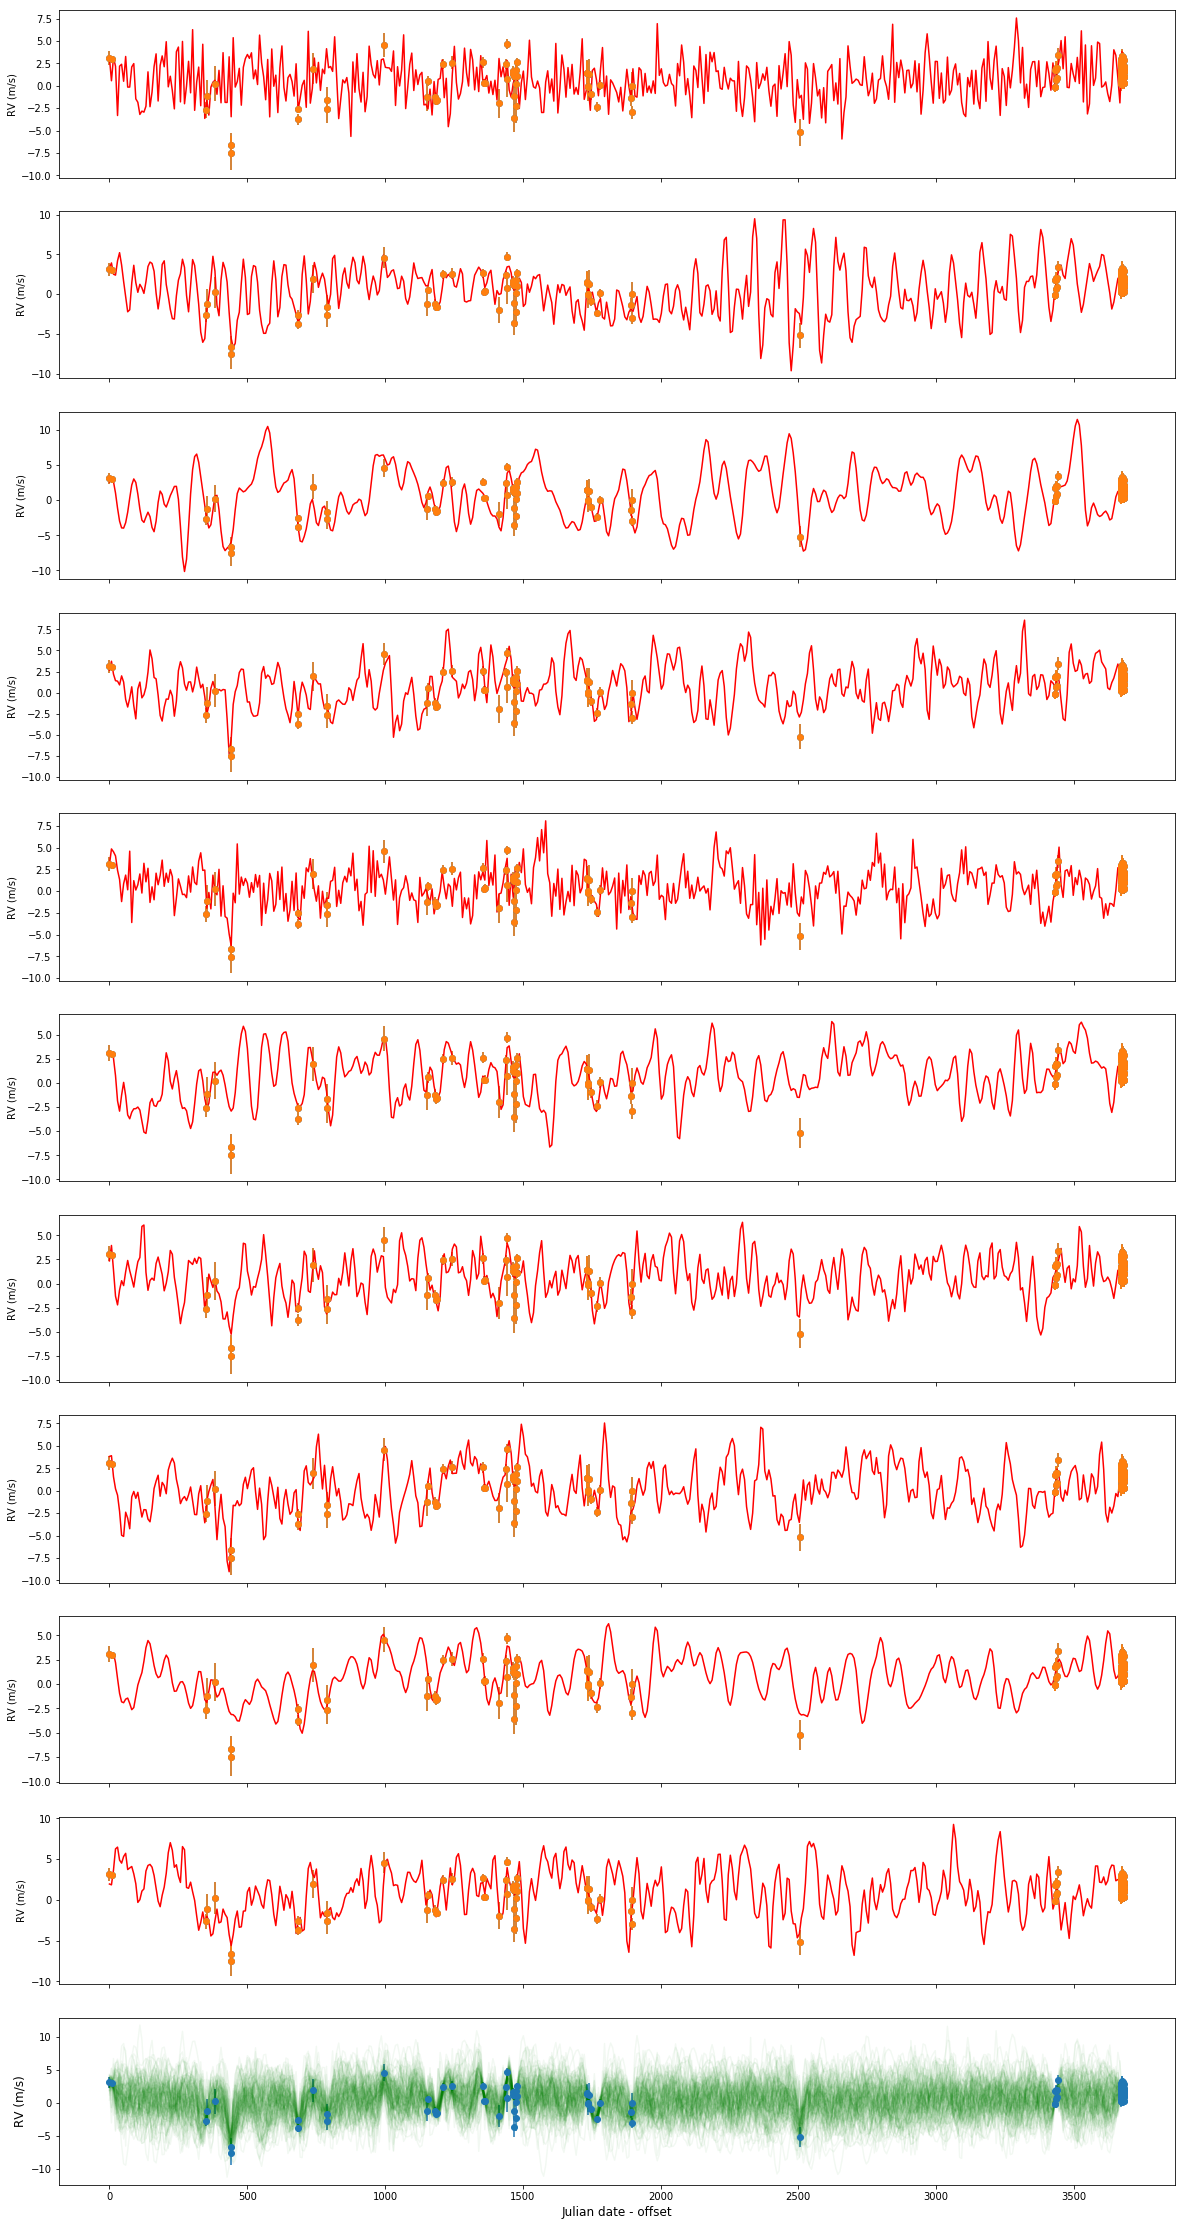

In [17]:
# Make a flat chain of samples with the initial burn-in discarded
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

#set up figure for 5 individual plots
fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(11, sharex=True, figsize=(20,40))
tt = np.linspace(alldates[0], alldates[-1], 501, endpoint=True)

# plot individual GPs to check if they are hitting the data
# Choose a sample
n = np.random.randint(0, samples.shape[0])
gp.set_parameter_vector(samples[n])
ax0.plot(tt, gp.sample_conditional(allRV, tt), "r")
ax0.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax0.set_ylabel("RV (m/s)")
n = np.random.randint(0, samples.shape[0])
gp.set_parameter_vector(samples[n])
ax1.plot(tt, gp.sample_conditional(allRV, tt), "r")
ax1.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax1.set_ylabel("RV (m/s)")
n = np.random.randint(0, samples.shape[0])
gp.set_parameter_vector(samples[n])
ax2.plot(tt, gp.sample_conditional(allRV, tt), "r")
ax2.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax2.set_ylabel("RV (m/s)")
n = np.random.randint(0, samples.shape[0])
gp.set_parameter_vector(samples[n])
ax3.plot(tt, gp.sample_conditional(allRV, tt), "r")
ax3.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax3.set_ylabel("RV (m/s)")    
n = np.random.randint(0, samples.shape[0])
gp.set_parameter_vector(samples[n])
ax4.plot(tt, gp.sample_conditional(allRV, tt), "r")
ax4.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax4.set_ylabel("RV (m/s)")
n = np.random.randint(0, samples.shape[0])
gp.set_parameter_vector(samples[n])
ax5.plot(tt, gp.sample_conditional(allRV, tt), "r")
ax5.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax5.set_ylabel("RV (m/s)")
n = np.random.randint(0, samples.shape[0])
gp.set_parameter_vector(samples[n])
ax6.plot(tt, gp.sample_conditional(allRV, tt), "r")
ax6.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax6.set_ylabel("RV (m/s)")
n = np.random.randint(0, samples.shape[0])
gp.set_parameter_vector(samples[n])
ax7.plot(tt, gp.sample_conditional(allRV, tt), "r")
ax7.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax7.set_ylabel("RV (m/s)")
n = np.random.randint(0, samples.shape[0])
gp.set_parameter_vector(samples[n])
ax8.plot(tt, gp.sample_conditional(allRV, tt), "r")
ax8.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax8.set_ylabel("RV (m/s)")    
n = np.random.randint(0, samples.shape[0])
gp.set_parameter_vector(samples[n])
ax9.plot(tt, gp.sample_conditional(allRV, tt), "r")
ax9.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax9.set_ylabel("RV (m/s)")

for i in range(100):
    # Choose a sample
    n = np.random.randint(0, samples.shape[0])
    gp.set_parameter_vector(samples[n])
    # Plot a single sample.
    ax10.plot(tt, gp.sample_conditional(allRV, tt), "g", alpha=0.05)
    
# Plot the real data
ax0.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax1.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax2.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax3.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax4.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax5.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax6.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax7.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax8.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax9.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax10.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax10.set_xlabel("Julian date - offset", fontsize='large')
ax10.set_ylabel("RV (m/s)", fontsize = 'large')


Strongest period signal in RV residuals: 17.813525979342252
False Alarm Prob.: 0.475


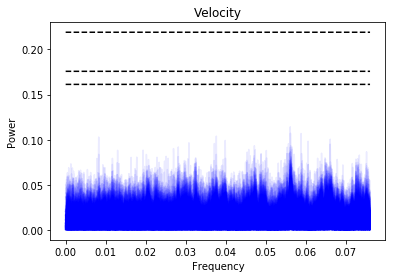

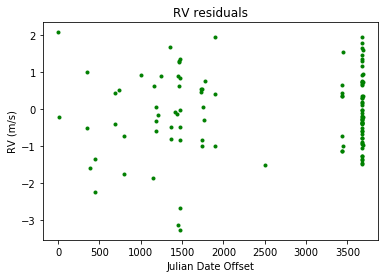

In [8]:
size = 300
RV_pds = np.zeros(size)
RV_pwr = np.zeros(size)
RV_fa = np.zeros(size)

fig, (ax1) = plt.subplots(1, sharex=True, figsize=(6,4))
for r in range(size):
    #get residuals
    resid = allRV - gp.sample_conditional(allRV,alldates)
    
    #periodogram
    ls = LombScargle(alldates, resid, allRVerr)
    xi, pspec = ls.autopower()
    sub = np.argmax(pspec)
    RV_pds[r] = 1.0/xi[sub]
    RV_pwr[r] = pspec[sub]
    
    ax1.plot(xi, pspec, 'b-', alpha=0.08)
    
fig, (ax3) = plt.subplots(1, sharex=True, figsize=(6,4))
ax3.plot(alldates, resid,'g.')
ax3.set_title('RV residuals')
ax3.set_ylabel("RV (m/s)")
ax3.set_xlabel("Julian Date Offset")



probabilities = [0.05, 0.01, 0.1]
levels = ls.false_alarm_level(probabilities, method='bootstrap')
level1 = np.zeros(len(xi))
level2 = np.zeros(len(xi))
level3 = np.zeros(len(xi))
for i in range(len(level1)):
    level1[i]= levels[0]
    level2[i] = levels[1]
    level3[i] = levels[2]
ax1.plot(xi,level1,'k--')
ax1.plot(xi,level2,'k--')
ax1.plot(xi,level3,'k--')

    
ax1.set_xlabel("Frequency")
ax1.set_title("Velocity")
ax1.set_ylabel("Power")


idx1 = np.argmax(RV_pwr)
print('Strongest period signal in RV residuals:',RV_pds[idx1])
print('False Alarm Prob.:', ls.false_alarm_probability(RV_pwr[idx1],method = 'bootstrap'))

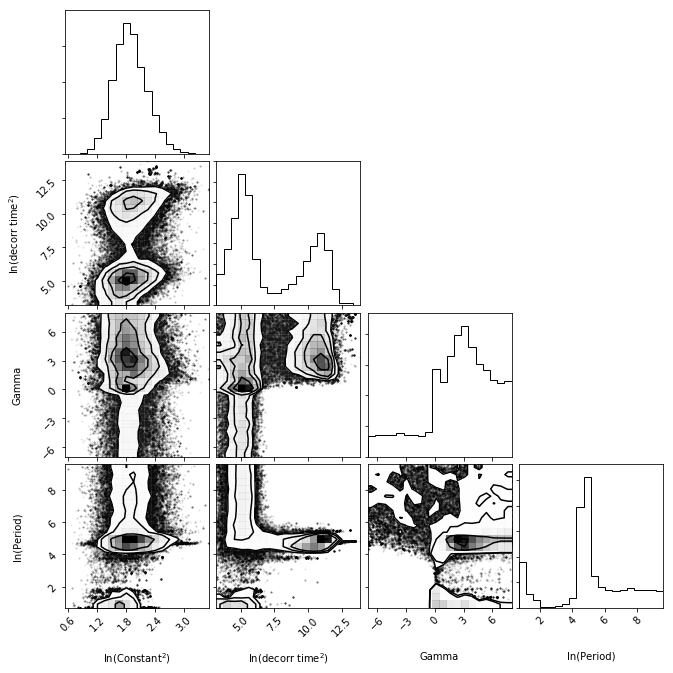

In [9]:
import corner
fig = corner.corner(samples, labels=["ln(Constant$^2$)", "ln(decorr time$^2$)", "Gamma", "ln(Period)"])

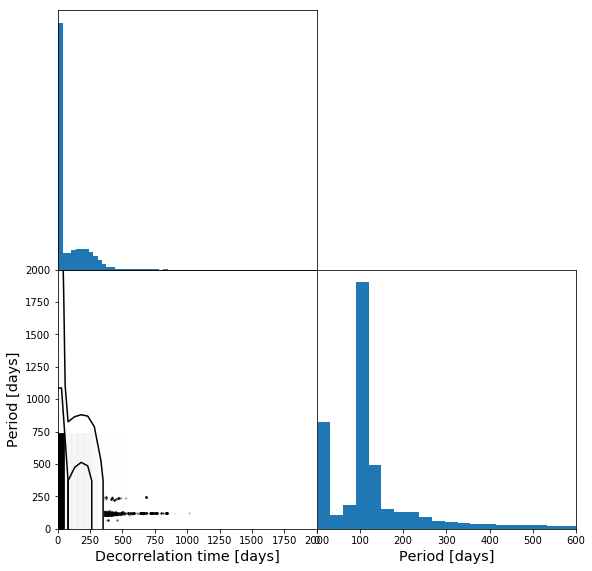

In [10]:
ln_decorr_times2 = samples[:,1]
decorr_times = np.sqrt(np.exp(ln_decorr_times2))
ln_periods = samples[:,3]
periods = np.exp(ln_periods)
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.1, 0.1, 0.45, 0.45])
ax2 = fig.add_axes([0.55, 0.1, 0.45, 0.45])
ax3 = fig.add_axes([0.1, 0.55, 0.45, 0.45], sharex=ax1)
corner.hist2d(decorr_times, periods, ax=ax1)
n1, bins1, patches = ax3.hist(decorr_times, bins=30)
n2, bins2, patches = ax2.hist(periods, bins=500)
ax1.set_xlabel("Decorrelation time [days]", fontsize="x-large")
ax2.set_xlim([0,600])
ax1.set_ylabel("Period [days]", fontsize="x-large")
ax2.set_xlabel("Period [days]", fontsize="x-large")
ax1.set_xlim([0,2000])
ax1.set_ylim([0,2000])
ax2.yaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax3.xaxis.set_visible(False)
# ax2.set_xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750])

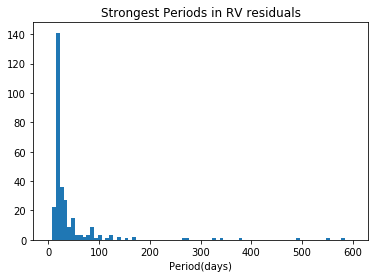

In [11]:
plt.hist(RV_pds, bins=80,range=(0,600))
plt.xlabel("Period(days)")
plt.title("Strongest Periods in RV residuals")
plt.show()

Text(0.5,1,'BIC Distribution')

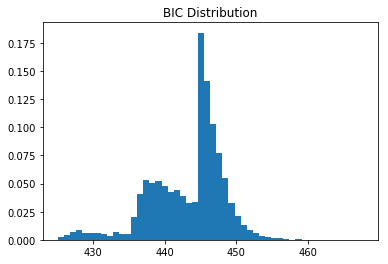

In [12]:
nsamples = nwalkers * nproduce
npts = len(alldates)
npars = 4
bics = np.zeros(nsamples)
for i in range(nsamples):
    bics[i] = np.log(npts) * npars + 2.*nll(samples[i,:])
n_bics, bins_bics, _ = plt.hist(bics, 50, density=True)
plt.title("BIC Distribution")